In [1]:
import pandas as pd
import numpy as np
import json
pd.set_option('display.max_columns', 500)

MARKET = "eth_cbbtc_usdc"
EVENTS_PATH = "/Users/yegortrussov/Documents/ml/lending_protocols/dataset_collection/data/markets_labelled"
HOURLY_MARKET_PATH = "/Users/yegortrussov/Documents/ml/lending_protocols/dataset_collection/data/markets_hourly_data"

df = pd.read_csv(f"{EVENTS_PATH}/{MARKET}.csv")
market_df = pd.read_csv(f"{HOURLY_MARKET_PATH}/{MARKET}.csv")

df.head(2)

,hash,type,timestamp,user_address,assets,assets_usd,liquidated_assets,liquidated_assets_usd,market,datetime,market_address,total_supply_before,total_borrow_before,total_supply_after,total_borrow_after,utilization_before,utilization_after,tx_actions,borrow_rate_before,supply_rate_before,borrow_rate_after,supply_rate_after,collateral_price,loan_asset_price,collateral_before,collateral_value_before,debt_before,ltv_before,collateral_after,collateral_value_after,debt_after,ltv_after,health_factor_before,health_factor_after,event_type,vault_flg,volatility_1h,drawdown_1h,trend_1h,volatility_6h,drawdown_6h,trend_6h,volatility_24h,drawdown_24h,trend_24h,hash_short,event_sequence_type
0,0xcbf9186fe08ab70d98098d274e46f380248321e1bc07...,MarketSupply,1757435615,0x0000000000000000000000000000000000000001,1100000,1.099788,0,0.0,eth_cbbtc_usdc,2025-09-09 16:33:35,0x64d65c9a2d91c36d56fbc42d69e979335320169b3df6...,4.708136e+08,3.763097e+08,4.708139e+08,3.763100e+08,0.799275,0.799275,1,0.041319,0.033026,0.041319,0.033026,111014.000000,0.999803,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,loan_position_supply,False,0,0,0,0.003739,0.0,-0.015004,0.003234,0.000000,-0.012060,0xcbf9186f,loan_position_supply
1,0xc7938048f930dcad275757ef6531bc27cce264d6cead...,MarketSupply,1761595235,0x000000000000000000000000000000000000dEaD,10586,0.010585,0,0.0,eth_cbbtc_usdc,2025-10-27 20:00:35,0x64d65c9a2d91c36d56fbc42d69e979335320169b3df6...,4.769922e+08,4.168996e+08,4.769930e+08,4.169004e+08,0.874018,0.874018,1,0.044545,0.038934,0.044545,0.038934,114836.091413,0.999801,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,loan_position_supply,False,0,0,0,0.004437,0.0,-0.000236,0.003686,-0.012068,0.011874,0xc7938048,loan_position_supply


In [2]:
%load_ext autoreload

In [26]:
%autoreload 2
from utils import (
    select_users_by_period,
    create_hourly_user_dataset,
)


In [17]:
def get_users_with_leverage(df_actions, start_date, end_date, window_hours=24, threshold_date=None):
    filtered_actions = select_users_by_period(df_actions, start_date, end_date, threshold_date)
    
    open_events = filtered_actions[filtered_actions['event_sequence_type'] == 'position_open'][['user_address', 'timestamp']].copy()
    open_events = open_events.rename(columns={'timestamp': 'open_time'})
    
    leverage_counts = []
    for user in open_events['user_address'].unique():
        user_open = open_events[open_events['user_address'] == user]['open_time'].iloc[0]
        user_df = filtered_actions[filtered_actions['user_address'] == user]
        
        window_end = user_open + window_hours * 3600
        window_events = user_df[(user_df['timestamp'] >= user_open) & (user_df['timestamp'] <= window_end)]
        
        leverage_count = len(window_events[window_events['event_sequence_type'] == 'borrow_more_w_collateral'])
        leverage_counts.append({'user_address': user, 'leverage_factor': leverage_count})
    
    leverage_df = pd.DataFrame(leverage_counts)
    result = filtered_actions.merge(leverage_df, on='user_address', how='left')
    result["leverage_factor"] += 1
    
    return result

In [18]:
leveraged_positions = get_users_with_leverage(
    df,
    "2025-06-01",
    "2025-08-01",
    threshold_date="2025-12-01",
)
leveraged_positions.head(2)

,hash,type,timestamp,user_address,assets,assets_usd,liquidated_assets,liquidated_assets_usd,market,datetime,market_address,total_supply_before,total_borrow_before,total_supply_after,total_borrow_after,utilization_before,utilization_after,tx_actions,borrow_rate_before,supply_rate_before,borrow_rate_after,supply_rate_after,collateral_price,loan_asset_price,collateral_before,collateral_value_before,debt_before,ltv_before,collateral_after,collateral_value_after,debt_after,ltv_after,health_factor_before,health_factor_after,event_type,vault_flg,volatility_1h,drawdown_1h,trend_1h,volatility_6h,drawdown_6h,trend_6h,volatility_24h,drawdown_24h,trend_24h,hash_short,event_sequence_type,leverage_factor
0,0x83231516f9d8d713409c97ccd4178ba8b6d5cab06b62...,MarketSupplyCollateral,1751562251,0x0A009741192Aa0BFFE53B376E000CE7435F00012,100000000,109277.139173,0,0.0,eth_cbbtc_usdc,2025-07-03 17:04:11,0x64d65c9a2d91c36d56fbc42d69e979335320169b3df6...,1.733431e+08,1.444619e+08,1.733435e+08,1.445023e+08,0.833387,0.833618,2,0.038103,0.031755,0.038111,0.031771,109356.0,0.99988,0.0,0.0,0.0,0.0,1.0,109356.0,39995.2,0.365778,0.0,2.351718,position_open,False,0,0,0,0.00306,-0.001436,-0.00398,0.00252,-0.006237,0.002255,0x83231516,position_open,9
1,0x83231516f9d8d713409c97ccd4178ba8b6d5cab06b62...,MarketBorrow,1751562251,0x0A009741192Aa0BFFE53B376E000CE7435F00012,40000000000,39993.017600,0,0.0,eth_cbbtc_usdc,2025-07-03 17:04:11,0x64d65c9a2d91c36d56fbc42d69e979335320169b3df6...,1.733431e+08,1.444619e+08,1.733435e+08,1.445023e+08,0.833387,0.833618,2,0.038103,0.031755,0.038111,0.031771,109356.0,0.99988,0.0,0.0,0.0,0.0,1.0,109356.0,39995.2,0.365778,0.0,2.351718,position_open,False,0,0,0,0.00306,-0.001436,-0.00398,0.00252,-0.006237,0.002255,0x83231516,position_open,9


In [22]:
leveraged_positions[leveraged_positions["leverage_factor"]==1]["user_address"].unique()[:10]

array(['0x0eD6210b49f8d33164f49a89a1De16BDAc28ff41',
       '0x1044566e87C868cF9a642eB9809d70a0fc0aF997',
       '0x141DB6EF072Dde75479776d7709610b3Dac650A3',
       '0x18e6f9825272EFd477344937209848D5372AD5b1',
       '0x1ADB67a4C80A760579378624714DC01b89E69549',
       '0x1Dbf406A83692Bf51179678f9ad1Caa25ee61D00',
       '0x1be45feF92C4E2538fEcd150757Ed62b7B3757D7',
       '0x1e50Ae17fCd800D50bb559D71cfD42a71e2AA3e6',
       '0x1e5d1A4Bb553309E39fC1D192452899fa8314582',
       '0x257946459a997f7E692A336beA8eB19600c47bB4'], dtype=object)

In [24]:
df[df["user_address"] == "0x1044566e87C868cF9a642eB9809d70a0fc0aF997"][[
        "datetime",
    "type",
    "debt_after",
    "collateral_value_after",
    "ltv_after",
    "event_type",
    "event_sequence_type",
    "hash"
]]

,datetime,type,debt_after,collateral_value_after,ltv_after,event_type,event_sequence_type,hash
3113,2025-07-17 08:55:47,MarketBorrow,49995.100000,236642.000000,0.211290,position_open,position_open,0x8b3d04cc9b02bac876fcfb30e9dda6f3402d8c3f6ec4...
3114,2025-07-17 08:55:47,MarketSupplyCollateral,49995.100000,236642.000000,0.211290,position_open,position_open,0x8b3d04cc9b02bac876fcfb30e9dda6f3402d8c3f6ec4...
3115,2025-07-17 22:55:23,MarketRepay,-6.113495,239398.000000,-0.000026,repay_full,position_close,0xaf27f000835a36b3a21b46bf9b43fc5c7dd67ab53064...
3116,2025-07-17 22:57:47,MarketWithdrawCollateral,-6.113495,0.000000,0.000000,position_close,position_close,0xc62b0d8c388e6e607f35b645cdfebbe2d5a5bcc05332...
3117,2025-11-24 17:21:59,MarketSupplyCollateral,114981.293856,174434.000456,0.659240,position_open,position_open,0x7f7332e84ca4cd866be27aac564b3d0cbf207ac0ae22...
3118,2025-11-24 17:21:59,MarketBorrow,114981.293856,174434.000456,0.659240,position_open,position_open,0x7f7332e84ca4cd866be27aac564b3d0cbf207ac0ae22...
3119,2025-11-24 17:30:59,MarketSupplyCollateral,204951.891921,264321.270017,0.775548,borrow_more_w_collateral,borrow_more_w_collateral,0x3a68df21891f17f414e83113b969df28fb895edd78cc...
3120,2025-11-24 17:30:59,MarketBorrow,204951.891921,264321.270017,0.775548,borrow_more_w_collateral,borrow_more_w_collateral,0x3a68df21891f17f414e83113b969df28fb895edd78cc...
3121,2025-11-25 11:58:47,MarketRepay,104968.946521,174754.580892,0.600808,repay_partial,repay_partial,0x8b59d358fb1ab0399f20e29af525d34e7d27b13d3978...
3122,2025-11-25 11:58:47,MarketWithdrawCollateral,104968.946521,174754.580892,0.600808,repay_partial,repay_partial,0x8b59d358fb1ab0399f20e29af525d34e7d27b13d3978...


In [27]:
hourly_df = create_hourly_user_dataset(
    leveraged_positions,
    market_df,
    n_hours=1,
)
hourly_df.shape

(35648, 16)

In [82]:
def add_time_difference_features(hourly_df, lookback_hours=[3, 6], diff_fields=['ltv', 'collateral_price', 'market_utilization']):
    df = hourly_df.sort_values(['user_address', 'timestamp']).copy()
    
    open_times = df.groupby('user_address')['timestamp'].min().reset_index()
    open_times.columns = ['user_address', 'open_timestamp']
    df = df.merge(open_times, on='user_address', how='left')
    
    open_values = df[df['timestamp'] == df['open_timestamp']].copy()
    open_values_dict = {}
    for field in diff_fields:
        open_values_dict[f'open_{field}'] = open_values.set_index('user_address')[field].to_dict()
    
    for field in diff_fields:
        df[f'{field}_vs_open'] = df.apply(
            lambda row: row[field] - open_values_dict[f'open_{field}'].get(row['user_address'], 0), 
            axis=1
        )
    
    for hours in lookback_hours:
        seconds = hours * 3600
        for field in diff_fields:
            df[f'{field}_{hours}h_ago'] = df.groupby('user_address')[field].shift(1)
            df[f'{field}_vs_{hours}h'] = df[field] - df[f'{field}_{hours}h_ago']
            df = df.drop(columns=[f'{field}_{hours}h_ago'])
    
    # Drop helper column
    df = df.drop(columns=['open_timestamp'])
    
    return df.fillna(0)
hourly_df1 = add_time_difference_features(
    hourly_df,
)

In [74]:
hourly_df1

,user_address,timestamp,datetime,collateral,debt,ltv,action,total_supply,total_borrow,market_utilization,borrow_rate,supply_rate,collateral_price,loan_asset_price,volatility_6h,drawdown_6h,ltv_vs_open,collateral_price_vs_open,market_utilization_vs_open,ltv_vs_3h,collateral_price_vs_3h,market_utilization_vs_3h,ltv_vs_6h,collateral_price_vs_6h,market_utilization_vs_6h
0,0x0A009741192Aa0BFFE53B376E000CE7435F00012,1751562251,2025-07-03 17:04:11,1.000000,39995.200000,0.365148,position_open,1.733431e+08,1.444619e+08,0.833387,0.038119,0.031768,109521.000000,0.999905,0.003040,-0.002940,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00
1,0x0A009741192Aa0BFFE53B376E000CE7435F00012,1751565851,2025-07-03 18:04:11,5.682068,341653.146702,0.548793,borrow_more_w_collateral,1.736643e+08,1.450795e+08,0.835402,0.038171,0.031889,109546.000000,0.999830,0.003060,-0.001436,0.183645,25.000000,0.002015,0.183645,25.000000,2.014834e-03,0.183645,25.000000,2.014834e-03
2,0x0A009741192Aa0BFFE53B376E000CE7435F00012,1751569451,2025-07-03 19:04:11,5.682068,341653.146702,0.548061,none,1.733649e+08,1.450801e+08,0.836848,0.038203,0.031971,109701.000000,0.999909,0.002082,-0.003168,0.182913,180.000000,0.003461,-0.000732,155.000000,1.446250e-03,-0.000732,155.000000,1.446250e-03
3,0x0A009741192Aa0BFFE53B376E000CE7435F00012,1751573051,2025-07-03 20:04:11,5.682068,341653.146702,0.547774,none,1.733199e+08,1.450807e+08,0.837069,0.038195,0.031973,109758.000000,0.999905,0.002094,-0.003355,0.182626,237.000000,0.003682,-0.000287,57.000000,2.205360e-04,-0.000287,57.000000,2.205360e-04
4,0x0A009741192Aa0BFFE53B376E000CE7435F00012,1751576651,2025-07-03 21:04:11,5.682068,341653.146702,0.547774,none,1.733201e+08,1.450810e+08,0.837070,0.038181,0.031960,109758.000000,0.999905,0.001497,-0.003663,0.182626,237.000000,0.003682,0.000000,0.000000,7.920488e-07,0.000000,0.000000,7.920488e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35643,0xeD9c58b7B8314703591fEfF77014e60aCe2532e7,1762277903,2025-11-04 17:38:23,3.005217,159967.680000,0.517123,none,4.837659e+08,4.089722e+08,0.845393,0.041850,0.035380,102914.683254,0.999803,0.005086,0.000000,0.032288,-6849.316746,-0.050855,0.002500,-500.236549,-4.265364e-03,0.002500,-500.236549,-4.265364e-03
35644,0xeD9c58b7B8314703591fEfF77014e60aCe2532e7,1762281503,2025-11-04 18:38:23,3.005217,159967.680000,0.526383,none,4.858687e+08,4.078238e+08,0.839370,0.041619,0.034934,101095.298565,0.999715,0.002335,0.000000,0.041548,-8668.701435,-0.056877,0.009260,-1819.384689,-6.022383e-03,0.009260,-1819.384689,-6.022383e-03
35645,0xeD9c58b7B8314703591fEfF77014e60aCe2532e7,1762285103,2025-11-04 19:38:23,3.005217,-3158.578909,-0.010490,position_close,4.874439e+08,4.048512e+08,0.830560,0.041287,0.034292,100169.148454,0.999751,0.005923,0.000000,-0.495325,-9594.851546,-0.065688,-0.536873,-926.150111,-8.810776e-03,-0.536873,-926.150111,-8.810776e-03
35646,0xf59362DeFfF3De62f6D757E155f1842a3A888982,1751151599,2025-06-28 22:59:59,3.367935,279956.600000,0.774659,position_open,1.589087e+08,1.150722e+08,0.724141,0.037003,0.026796,107283.000000,0.999803,0.001626,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00


In [75]:
def remove_similar_hours(hourly_df, diff_thresholds, min_events_cnt=5):
    """
    Remove rows where ALL specified columns have changes below thresholds.
    Always keep rows with actions and ensure minimum events per user.
    
    Parameters:
    hourly_df: DataFrame from create_hourly_user_dataset
    diff_thresholds: dict {"column_name": max_absolute_diff}
    min_events_cnt: minimum rows to keep per user
    """
    df = hourly_df.sort_values(['user_address', 'timestamp']).copy()
    result_dfs = []
    
    for user, user_df in df.groupby('user_address'):
        # Always keep action rows
        action_mask = user_df['action'] != 'none'
        keep_indices = set(user_df[action_mask].index)
        
        # If user has too few rows, keep all
        if len(user_df) <= min_events_cnt:
            result_dfs.append(user_df)
            continue
        
        # Check consecutive rows for similarity
        for i in range(1, len(user_df)):
            prev_row = user_df.iloc[i-1]
            curr_row = user_df.iloc[i]
            
            # Check if ALL columns are within thresholds
            similar = True
            for col, threshold in diff_thresholds.items():
                if col not in curr_row or col not in prev_row:
                    continue
                diff = abs(curr_row[col] - prev_row[col])
                if diff > threshold:
                    similar = False
                    break
            
            # If not similar, keep current row
            if not similar:
                keep_indices.add(curr_row.name)
        
        # Ensure we keep at least min_events_cnt
        if len(keep_indices) < min_events_cnt:
            keep_indices = set(user_df.index)
        
        result_dfs.append(user_df.loc[list(keep_indices)])
    
    return pd.concat(result_dfs).sort_values(['user_address', 'timestamp'])

# Example usage:
thresholds = {
    'market_utilization': 0.01,
    'ltv': 0.005,           # 1% change in LTV
    'borrow_rate': 0.005,   # 0.1% rate change
    'collateral_price': 1000,
}

filtered_hourly_df = remove_similar_hours(hourly_df1, thresholds, min_events_cnt=5)
filtered_hourly_df.shape, hourly_df.shape

((6669, 25), (35648, 16))

In [81]:
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
def plot_user_metrics(df, fields, user_address=None):
    """
    Plot time series metrics with action markers using Plotly.
    """
    if user_address:
        plot_df = df[df['user_address'] == user_address].copy()
        if plot_df.empty:
            print(f"No data for user {user_address}")
            return
    else:
        plot_df = df.copy()
    plot_df["ltv"] = plot_df["ltv"].clip(0,1)
    
    plot_df = plot_df.sort_values('timestamp')
    plot_df['datetime'] = pd.to_datetime(plot_df['timestamp'], unit='s')
    
    # Create subplot with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": len(fields) > 1}]])
    
    colors = px.colors.qualitative.Plotly

    plot_df[fields[0]] = plot_df[fields[0]].clip(0, plot_df[fields[0]].max())
    
    # Add first field
    fig.add_trace(
        go.Scatter(x=plot_df['datetime'], y=plot_df[fields[0]],
                  mode='lines+markers',
                  name=fields[0],
                  line=dict(color=colors[0], width=2),
                  marker=dict(size=4)),
        secondary_y=False
    )
    
    # Add second field if exists
    if len(fields) > 1:
        fig.add_trace(
            go.Scatter(x=plot_df['datetime'], y=plot_df[fields[1]],
                      mode='lines+markers',
                      name=fields[1],
                      line=dict(color=colors[1], width=2),
                      marker=dict(size=4)),
            secondary_y=True
        )
    
    # Add action markers
    action_df = plot_df[plot_df['action'] != 'none'].copy()
    
    # Get y-axis ranges
    
    print(plot_df[fields[0]].min())
    y1_min, y1_max = plot_df[fields[0]].min(), plot_df[fields[0]].max()
    y1_min = max(y1_min,0)
    y1_range = y1_max - y1_min
    print(y1_range)
    
    for i, (idx, row) in enumerate(action_df.iterrows()):
        # Add vertical line
        fig.add_vline(x=row['datetime'], line_dash="dash", 
                     line_color="gray", opacity=0.5, line_width=1)
        
        # Add action label using first y-axis scale
        y_pos = y1_max - (i * y1_range * 0.05)
        fig.add_annotation(
            x=row['datetime'],
            y=y_pos,
            text=row['action'],
            showarrow=True,
            arrowhead=2,
            arrowsize=1,
            arrowwidth=1,
            arrowcolor="darkgray",
            ax=40,
            ay=-20,
            font=dict(size=10),
            bgcolor="rgba(255, 255, 0, 0.7)",
            bordercolor="black",
            borderwidth=1,
            borderpad=4,
            yref="y"  # Explicitly use left axis
        )
    
    # Update layout
    title = f"User Metrics - {user_address[:10]}..." if user_address else "User Metrics - All Users"
    fig.update_layout(
        title=dict(text=title, x=0.5, font=dict(size=16)),
        hovermode='x unified',
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
        template="plotly_white"
    )
    
    # Update axes
    fig.update_xaxes(title_text="Time", tickformat="%Y-%m-%d %H:%M")
    fig.update_yaxes(title_text=fields[0], secondary_y=False)
    if len(fields) > 1:
        fig.update_yaxes(title_text=fields[1], secondary_y=True)
    
    fig.show()

# Example usage
plot_user_metrics(filtered_hourly_df, ['ltv_vs_open', 'ltv'], user_address='0x1ADB67a4C80A760579378624714DC01b89E69549')

0.0
0.4718592269972486


In [78]:
hourly_df1[hourly_df1["user_address"] == "0x1ADB67a4C80A760579378624714DC01b89E69549"].head(2)

,user_address,timestamp,datetime,collateral,debt,ltv,action,total_supply,total_borrow,market_utilization,borrow_rate,supply_rate,collateral_price,loan_asset_price,volatility_6h,drawdown_6h,ltv_vs_open,collateral_price_vs_open,market_utilization_vs_open,ltv_vs_3h,collateral_price_vs_3h,market_utilization_vs_3h,ltv_vs_6h,collateral_price_vs_6h,market_utilization_vs_6h
2888,0x1ADB67a4C80A760579378624714DC01b89E69549,1752012587,2025-07-08 22:09:47,36.461563,9.731915e+05,0.245012,position_open,1.784150e+08,1.547901e+08,0.867585,0.037503,0.032537,108926.0,0.9999,0.003385,-0.003250,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000
2889,0x1ADB67a4C80A760579378624714DC01b89E69549,1752016187,2025-07-08 23:09:47,36.461563,1.536485e+06,0.386828,borrow_more,1.781493e+08,1.563537e+08,0.877655,0.037819,0.033192,108926.0,0.9999,0.003492,-0.004756,0.141816,0.0,0.010071,0.141816,0.0,0.010071,0.141816,0.0,0.010071


In [94]:
def prepare_dataset_for_log(df, market_meta_df, date_start, date_end, date_cutoff, n_hours, thresholds):

    cohort_actions = get_users_with_leverage(
        df,
        start_date=date_start,
        end_date=date_end,
        threshold_date=date_cutoff,
    )
    hourly_data = create_hourly_user_dataset(
        cohort_actions,
        market_meta_df,
        n_hours=n_hours,
        threshold_date="2025-11-01",
    )
    hourly_data = add_time_difference_features(
        hourly_data,
        diff_fields=['ltv', 'collateral_price', 'market_utilization', "borrow_rate"]
    )
    filtered_hourly_df = remove_similar_hours(hourly_data, thresholds, min_events_cnt=5)

    return filtered_hourly_df

thresholds = {
    'market_utilization': 0.01,
    'ltv': 0.005,           # 1% change in LTV
    'borrow_rate': 0.005,   # 0.1% rate change
    'collateral_price': 1000,
}

raw_hourly_df = prepare_dataset_for_log(
    df,
    market_df,
    "2025-06-01",
    "2025-09-01",
    "2025-12-01",
    1,
    thresholds,
)


In [95]:
raw_hourly_df.head(4)

,user_address,timestamp,datetime,collateral,debt,ltv,action,total_supply,total_borrow,market_utilization,borrow_rate,supply_rate,collateral_price,loan_asset_price,volatility_6h,drawdown_6h,ltv_vs_open,collateral_price_vs_open,market_utilization_vs_open,borrow_rate_vs_open,ltv_vs_3h,collateral_price_vs_3h,market_utilization_vs_3h,borrow_rate_vs_3h,ltv_vs_6h,collateral_price_vs_6h,market_utilization_vs_6h,borrow_rate_vs_6h
0,0x0553a26b0E53be5c90ca3dD1745E4575Ef96E183,1755477455,2025-08-18 00:37:35,0.498686,29994.12,0.511332,position_open,3.171248e+08,2.524274e+08,0.795988,0.042261,0.033640,117615.0,0.999901,0.001196,-0.002490,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
3,0x0553a26b0E53be5c90ca3dD1745E4575Ef96E183,1755488255,2025-08-18 03:37:35,0.498686,29994.12,0.519247,none,3.175031e+08,2.520613e+08,0.793886,0.042096,0.033421,115821.0,0.999891,0.002486,-0.001465,0.007915,-1794.0,-0.002101,-0.000164,0.006342,-1422.0,-0.001458,-0.000084,0.006342,-1422.0,-0.001458,-0.000084
22,0x0553a26b0E53be5c90ca3dD1745E4575Ef96E183,1755556655,2025-08-18 22:37:35,0.498686,29994.12,0.515278,none,3.134264e+08,2.670566e+08,0.852055,0.043792,0.037314,116707.0,0.999839,0.002535,-0.005213,0.003946,-908.0,0.056067,0.001531,-0.001188,272.0,0.047958,0.001798,-0.001188,272.0,0.047958,0.001798
26,0x0553a26b0E53be5c90ca3dD1745E4575Ef96E183,1755571055,2025-08-19 02:37:35,0.498686,29994.12,0.518982,none,3.223626e+08,2.670614e+08,0.828450,0.042826,0.035480,115872.0,0.999820,0.002596,-0.000172,0.007650,-1743.0,0.032463,0.000565,0.002180,-489.0,-0.012509,-0.000491,0.002180,-489.0,-0.012509,-0.000491


In [96]:
def create_model_dataset(hourly_user_df, target_horizon_hours=1):
    df = hourly_user_df.sort_values(['user_address', 'timestamp']).copy()
    df["log_debt"] = np.log1p(df["debt"])
    
    df['action_next'] = df.groupby('user_address')['action'].shift(-1).apply(lambda x: 1 if x != 'none' else 0)
    df = df[df.groupby('user_address')['timestamp'].transform(lambda x: x != x.max())].copy()   

    df 

    return df[[
        "user_address",
        "timestamp",
        
        "borrow_rate",
        "borrow_rate_vs_open",

        "ltv",
        "ltv_vs_open",

        "collateral_price_vs_open",
        "collateral_price_vs_6h",

        "log_debt",

        "volatility_6h",
        "drawdown_6h",

        "action_next",
    ]].fillna(0)
model_df = create_model_dataset(
    raw_hourly_df,
    3,
)

/Users/yegortrussov/Library/Python/3.9/lib/python/site-packages/pandas/core/arraylike.py:399: RuntimeWarning:

invalid value encountered in log1p



=== Model Performance ===
Train size: 29533, Test size: 7384
Action rate in test: 0.012
ROC-AUC: 0.674

=== Feature Significance (sorted by p-value) ===
                 feature  coefficient      p_value  significant sign
               intercept    -4.353173 0.000000e+00         True    -
                log_debt     0.633715 5.349475e-36         True    +
collateral_price_vs_open    -0.422016 8.782636e-23         True    -
             borrow_rate    -0.943617 1.644548e-10         True    -
     borrow_rate_vs_open     0.486571 6.312961e-04         True    +
           volatility_6h    -0.142899 8.378927e-03         True    -
                     ltv    -0.099820 4.560064e-02         True    -
  collateral_price_vs_6h     0.079576 5.963170e-02        False    +
             ltv_vs_open    -0.072921 9.099842e-02        False    -
             drawdown_6h     0.057899 2.601332e-01        False    +


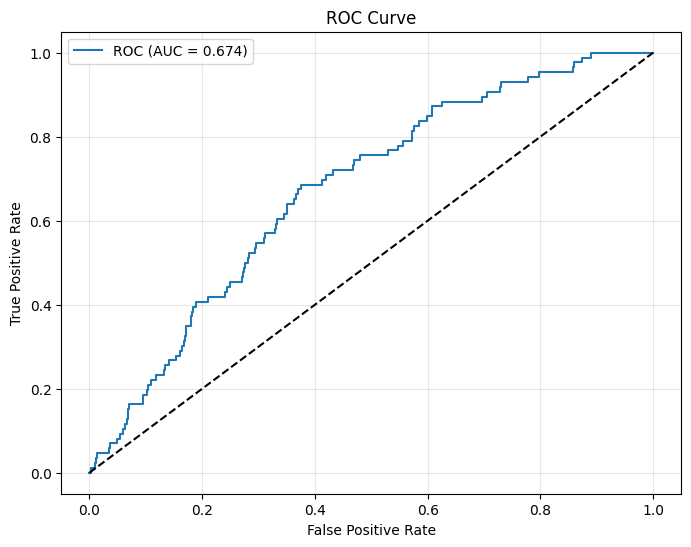

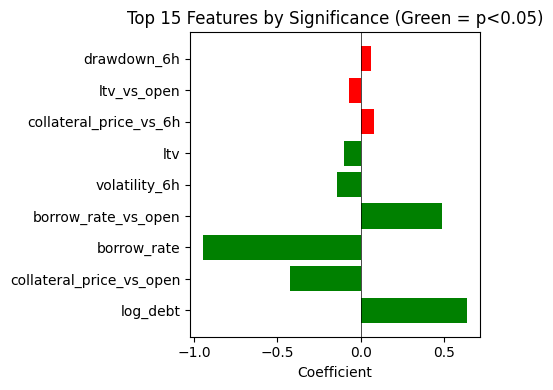

const                       0.000000e+00
borrow_rate                 1.644548e-10
borrow_rate_vs_open         6.312961e-04
ltv                         4.560064e-02
ltv_vs_open                 9.099842e-02
collateral_price_vs_open    8.782636e-23
collateral_price_vs_6h      5.963170e-02
log_debt                    5.349475e-36
volatility_6h               8.378927e-03
drawdown_6h                 2.601332e-01
dtype: float64
                           Logit Regression Results                           
Dep. Variable:            action_next   No. Observations:                29533
Model:                          Logit   Df Residuals:                    29523
Method:                           MLE   Df Model:                            9
Date:                Sun, 22 Feb 2026   Pseudo R-squ.:                 0.08013
Time:                        23:30:55   Log-Likelihood:                -2542.0
converged:                       True   LL-Null:                       -2763.4
Covariance Type:      

In [97]:
import statsmodels.api as sm


import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score

def train_logistic_model_statsmodels(model_df, verbose=True):
    feature_cols = [col for col in model_df.columns if col not in ['user_address', 'timestamp', 'action_next']]
    X = model_df[feature_cols].copy()
    y = model_df['action_next'].copy()
    
    split_idx = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    X_train_sm = sm.add_constant(X_train_scaled)
    X_test_sm = sm.add_constant(X_test_scaled)
    
    model_sm = sm.Logit(y_train, X_train_sm)
    result = model_sm.fit(disp=0, maxiter=1000)

    result.params.index = ['const'] + feature_cols
    result.bse.index = ['const'] + feature_cols

    y_prob = result.predict(X_test_sm)
    y_pred = (y_prob > 0.5).astype(int)

    roc_auc = roc_auc_score(y_test, y_prob)
    pr_auc = average_precision_score(y_test, y_prob)
    metrics = {'roc_auc': roc_auc, 'pr_auc': pr_auc}

    
    if verbose:
        print("=== Model Performance ===")
        print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")
        print(f"Action rate in test: {y_test.mean():.3f}")
        print(f"ROC-AUC: {roc_auc_score(y_test, y_prob):.3f}")
        
        # Feature importance with p-values
        coef_df = pd.DataFrame({
            'feature': ['intercept'] + feature_cols,
            'coefficient': result.params.values,
            'p_value': result.pvalues.values,
            'std_err': result.bse.values
        })
        
        coef_df['significant'] = coef_df['p_value'] < 0.05
        coef_df['sign'] = ['+' if c > 0 else '-' for c in coef_df['coefficient']]
        coef_df = coef_df.sort_values('p_value')
        
        print("\n=== Feature Significance (sorted by p-value) ===")
        pd.set_option('display.max_rows', None)
        print(coef_df[['feature', 'coefficient', 'p_value', 'significant', 'sign']].to_string(index=False))
        
        # Confidence intervals
        conf = result.conf_int()
        conf.columns = ['2.5%', '97.5%']
        coef_df = coef_df.join(conf)
        
        # Plot ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc_score(y_test, y_prob):.3f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        
        # Plot coefficient significance
        plt.figure(figsize=(5, 4))
        sig_features = coef_df[coef_df['feature'] != 'intercept'].head(15)
        colors = ['green' if s else 'red' for s in sig_features['significant']]
        plt.barh(sig_features['feature'], sig_features['coefficient'], color=colors)
        plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
        plt.xlabel('Coefficient')
        plt.title('Top 15 Features by Significance (Green = p<0.05)')
        plt.tight_layout()
        plt.show()
    
    # Return p-values for all features
    p_values = pd.Series(result.pvalues.values, index=['const'] + feature_cols)
    
    return result, scaler, p_values, metrics

model, result, coef_df, metrics = train_logistic_model_statsmodels(
    model_df,
    verbose=True
)

print(coef_df)
print(model.summary())

In [63]:
coef_df
5e-2

0.05